In [1]:
from select_top_counts import select_top_counts

selected = select_top_counts()

In [2]:
top = set(selected
    .sort_values('count', ascending=False)
    .iloc[: 200000, :]
    .lower_title.values.tolist()
)

del(selected)

In [3]:
import json

ids = []
with open('data/cleaned.jsonl', 'r') as file:
    for line in file:
        j = json.loads(line)
        if j['lower_title'] not in top:
            continue
        del(j['clean_text'])
        ids.append(j)

In [4]:
top_ids = set([x['id'] for x in ids])
del(ids)

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import json
import base64
import pandas as pd

X = []
with open('data/embeddings.jsonl', 'r') as file:
    for line in file:
        j = json.loads(line)
        if j['id'] not in top_ids:
            continue
        if j['embedding'] is None:
            continue
        j['embedding'] = np.frombuffer(base64.b64decode(j['embedding']))
        X.append(j)
X = pd.DataFrame(X)

In [6]:
X = np.array([x for x in X.embedding.to_numpy()])

# Select K

In [7]:
# from sklearn.cluster import KMeans
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import silhouette_score

# data = []

# for k in range(100, 400, 25):
#     print(k)
#     kmeans = KMeans(n_clusters=k, random_state=1)
#     labels = kmeans.fit_predict(X)
#     score = silhouette_score(X, labels)
#     print(score)
#     data.append({'score': score, 'k': k})

# sns.lineplot(data=pd.DataFrame(data), x='k', y='score')

Two different resolution for chosing K

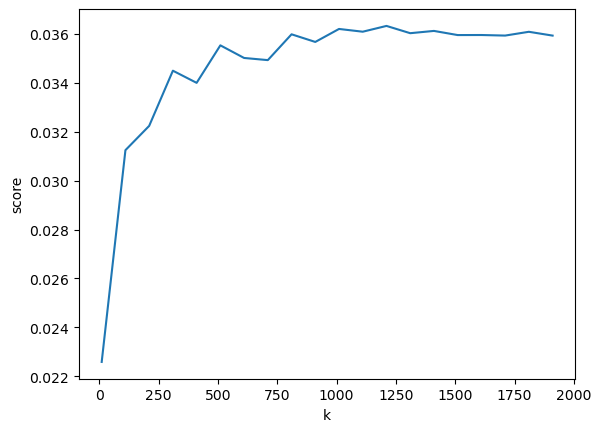

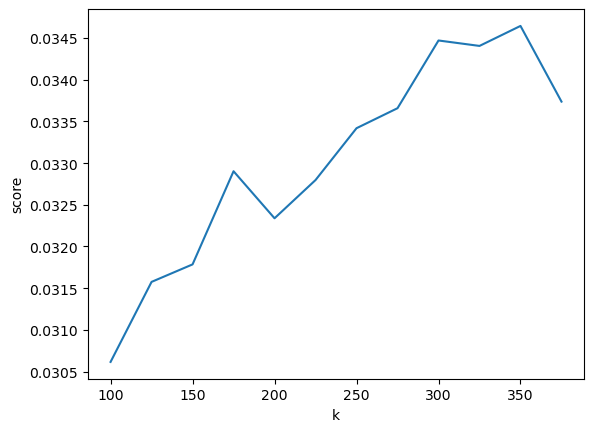

# Make clusters

In [8]:
# import sqlite3

# conn = sqlite3.Connection('data/data.db')
# cur = conn.cursor()
# cur.execute('select distinct cluster from articles')
# sorted(cur.fetchall())

In [9]:
km = KMeans(n_clusters=300, random_state=1).fit(X)

In [14]:
del(X)

In [27]:
import sqlite3

try:
    conn = sqlite3.Connection('data/data.db')
    cur = conn.cursor()

    QUERY = "select id, vector from embeddings where vector is not null"
    cur.execute(QUERY)

    data = []
    i = 0
    while True:
        i += 1
        print(i, len(set([x['cluster'] for x in data])))
        
        rows = cur.fetchmany(25000)

        if not rows:
            break

        ids = []
        features = []
        for id, vector in rows:
            vector = np.frombuffer(vector)
            if len(vector) == 0:
                continue
            ids.append(id)
            features.append(vector)

        features = np.array(features)

        pred = km.predict(features)
        
        data.extend([{'id': ids[i], 'cluster': int(pred[i])} for i in range(len(pred))])

    print(len(data))
    
except Exception as e:
    print(e)
finally:
    conn.close()

1 0
2 299
3 300
4 300
5 300
6 300
7 300
8 300
9 300
10 300
11 300
12 300
13 300
14 300
15 300
16 300
17 300
18 300
19 300
20 300
21 300
22 300
23 300
24 300
550741


In [28]:
with open('data/clusters.jsonl', 'a', encoding='utf-8') as file:
    for row in data:
        file.write(json.dumps(row) + '\n')